# Convolutional Neural Networks: Applications

## 1 - Packages


In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.model_selection import train_test_split

%matplotlib inline
np.random.seed(1)

2021-10-13 02:29:36.723827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/targets/x86_64-linux/lib/:/opt/oracle:/opt/oracle/lib/::
2021-10-13 02:29:36.723848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 2 - First Problem: Detecting smilling faces (Using Sequantial API)

In this problem, Bob wan't to open his door only to smilling people. So, we will use a basic CNN to detect if a person in front of Bob's door is smilling to allow him to enter.

### 2.1 - Load the Data and Split the Data into Train/Test Sets

Preprocessing the data ..

In [2]:
def load_happy_dataset():
    #The data is stocked in h5 files
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # our train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # our train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # our test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # our test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print("The outout is in: ", classes)

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
The outout is in:  [0 1]


### 2.2 - Example from the dataset 

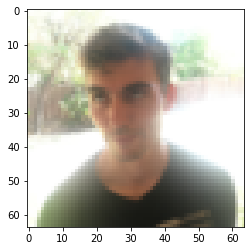

The person in the image is not smiling .


In [4]:
index = np.random.randint(X_train.shape[0])
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()
states = {0: "not smiling", 1: "smilling"}
print("The person in the image is", states[Y_train_orig[0][index]],".")

### 2-2 Our Happy Model

In [5]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model
    Arguments:
    None

    Returns:
    model -- TF Keras model
    """
    model = tf.keras.Sequential([
            tfl.InputLayer((64, 64, 3)),
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
            tfl.ZeroPadding2D(padding=3),
            ## Conv2D with 32 7x7 filters and stride of 1
            tfl.Conv2D(32, 7, strides=1),
            ## BatchNormalization for axis 3
            tfl.BatchNormalization(axis=3),
            ## ReLU
            tfl.ReLU(),
            ## Max Pooling 2D with default parameters
            tfl.MaxPool2D(),
            ## Flatten layer
            tfl.Flatten(),
            ## Dense layer with 1 unit for output & 'sigmoid' activation
            tfl.Dense(1, activation="sigmoid")
        ])
    
    return model

In [6]:
happy_model = happyModel()
happy_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

2021-10-13 02:29:44.774105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/targets/x86_64-linux/lib/:/opt/oracle:/opt/oracle/lib/::
2021-10-13 02:29:44.774141: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-13 02:29:44.774167: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux): /proc/driver/nvidia/version does not exist
2021-10-13 02:29:44.774426: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [8]:
print("Shape of the training set before spliting:",X_train.shape)
print("Shape of the training set labels before spliting:", Y_train.shape)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.22, shuffle = True)
print("Shape of the training set after spliting:",X_train.shape)
print("Shape of the validation set labels after spliting:", Y_train.shape)
print("Shape of the training set after spliting:",X_val.shape)

Shape of the training set before spliting: (600, 64, 64, 3)
Shape of the training set labels before spliting: (600, 1)
Shape of the training set after spliting: (468, 64, 64, 3)
Shape of the validation set labels after spliting: (468, 1)
Shape of the training set after spliting: (132, 64, 64, 3)


Training the model ..

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(64)
history = happy_model.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30


2021-10-13 02:29:54.163576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-13 02:29:54.182743: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


8/8 [==============================] - 2s 176ms/step - loss: 3.9636 - accuracy: 0.5064 - val_loss: 0.8073 - val_accuracy: 0.4697
Epoch 2/30
8/8 [==============================] - 1s 159ms/step - loss: 2.1017 - accuracy: 0.5556 - val_loss: 0.5551 - val_accuracy: 0.7424
Epoch 3/30
8/8 [==============================] - 1s 160ms/step - loss: 0.9573 - accuracy: 0.6966 - val_loss: 0.6274 - val_accuracy: 0.7348
Epoch 4/30
8/8 [==============================] - 1s 165ms/step - loss: 0.7574 - accuracy: 0.7650 - val_loss: 0.5007 - val_accuracy: 0.7500
Epoch 5/30
8/8 [==============================] - 1s 162ms/step - loss: 0.3248 - accuracy: 0.8974 - val_loss: 0.6547 - val_accuracy: 0.5833
Epoch 6/30
8/8 [==============================] - 1s 161ms/step - loss: 0.1963 - accuracy: 0.9145 - val_loss: 0.6676 - val_accuracy: 0.5833
Epoch 7/30
8/8 [==============================] - 1s 156ms/step - loss: 0.1965 - accuracy: 0.9252 - val_loss: 0.5384 - val_accuracy: 0.6591
Epoch 8/30
8/8 [===============

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

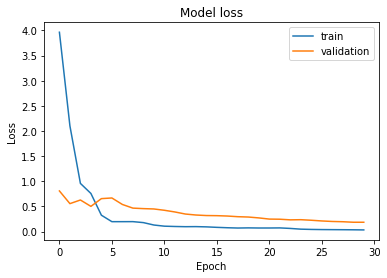

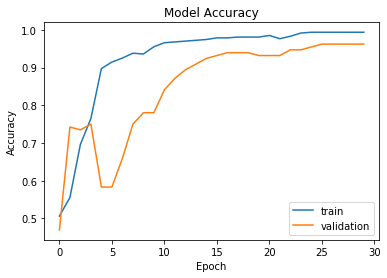

In [10]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss').set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy').set(xlabel='Epoch',ylabel='Accuracy')

In [11]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 19ms/step - loss: 0.2076 - accuracy: 0.9533


[0.20761486887931824, 0.95333331823349]

Our model is predicting correctly 95 % of our test set, which is very accurate.

## 3 - Second Problem: Sign language digits (with Functional API)

We will use Keras flexible Functional API to build a CNN that can differentiate between 6 sign language digits. 

### 3-1 Load the Data and Split the Data into Train/Test Sets

In [12]:
def load_signs_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # our train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # out train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # our test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # our test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [13]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 3.2 - Example from the dataset

y = 4


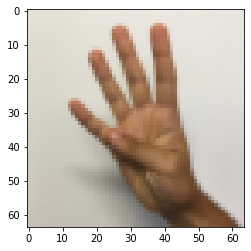

In [17]:
index = np.random.randint(X_train.shape[0])
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [18]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    
    Arguments:
    input_img -- input dataset

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(8, 4, strides=1, padding = 'same')(input_img)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='same')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(16, 2, strides=1, padding = 'same')(P1)
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='same')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer.
    outputs = tfl.Dense(6, activation='softmax')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [19]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 16)          0     

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 1s 40ms/step - loss: 1.8018 - accuracy: 0.1769 - val_loss: 1.7887 - val_accuracy: 0.1917
Epoch 2/100
17/17 [==============================] - 1s 35ms/step - loss: 1.7875 - accuracy: 0.1907 - val_loss: 1.7853 - val_accuracy: 0.1583
Epoch 3/100
17/17 [==============================] - 1s 35ms/step - loss: 1.7845 - accuracy: 0.2093 - val_loss: 1.7833 - val_accuracy: 0.2917
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 1.7807 - accuracy: 0.2500 - val_loss: 1.7797 - val_accuracy: 0.2167
Epoch 5/100
17/17 [==============================] - 1s 36ms/step - loss: 1.7764 - accuracy: 0.2611 - val_loss: 1.7758 - val_accuracy: 0.2833
Epoch 6/100
17/17 [==============================] - 1s 34ms/step - loss: 1.7704 - accuracy: 0.2981 - val_loss: 1.7711 - val_accuracy: 0.2250
Epoch 7/100
17/17 [==============================] - 1s 35ms/step - loss: 1.7633 - accuracy: 0.3111 - val_loss: 1.7640 - val_accuracy: 0.2583
Epoch 

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

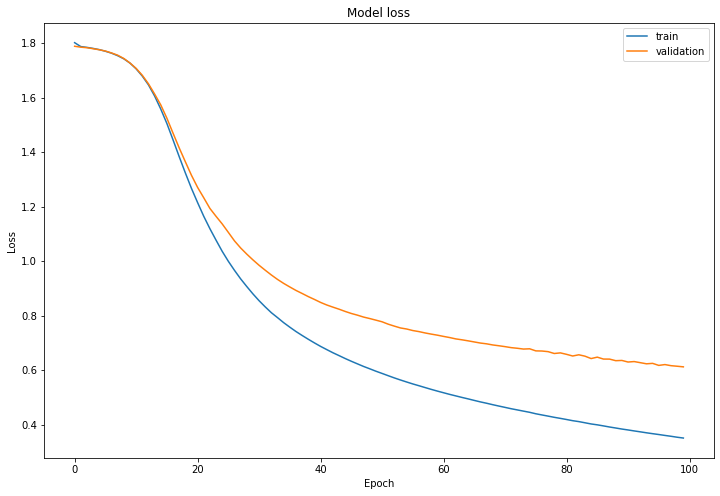

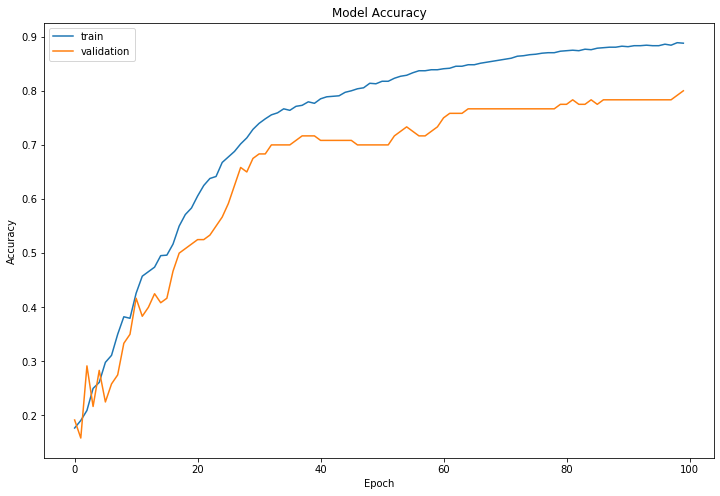

In [21]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')